# CV_LAB : Question 1
## author : Vishal Kashyap

In [ ]:
# coordinate frame : x is towards right , y is down

# should work with RGB images as well

In [41]:
## import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure


In [88]:
# load image with name as greyscale
im = cv2.imread("Name_Arial_72.jpeg",cv2.IMREAD_GRAYSCALE)

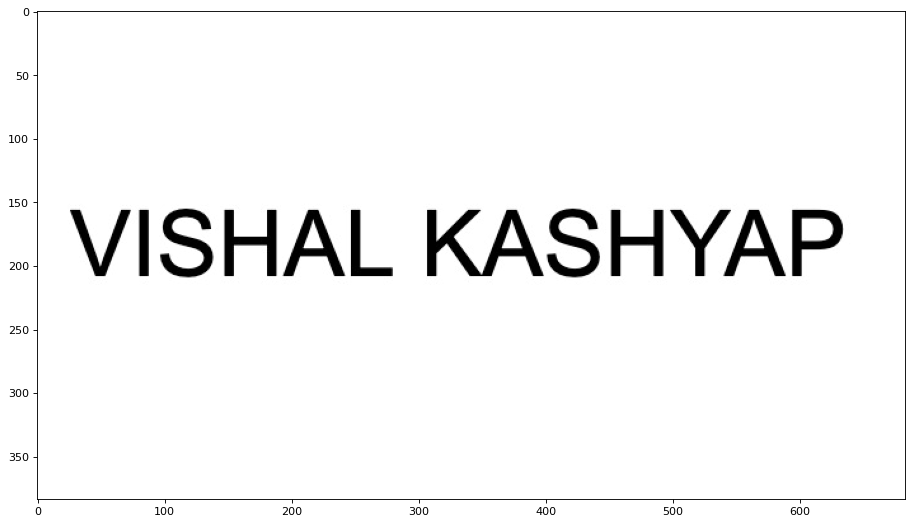

In [89]:
# check if image is loaded properly
figure(figsize=(14, 11), dpi=80)
plt.imshow(im,cmap='gray')


* It can be seen that origin of image lies on the top left corner. To rotate the image we need to find origin and rotate each pixel about that. 
* Here x-axis will be column of image and y-axis will be row of image.

## Try forward warping

In [118]:
# function to rotate image counter-clockwise by angle theta (forward warping)
# input : image, angle to rotate (counter-clockwise)
# output : rotated image

def ICV_rotate_image_fwd(im_old, theta, transformation):
    
    # step 1 : find center of image = int(max_row/col /2)
    x_center = int(im_old.shape[1]/2.0)
    y_center = int(im_old.shape[0]/2.0)
    
    # step 2 : find new location of each pixel after rotation and fill new matrix
    
    # new rotated image , initially all grey
    im_new = np.zeros(im_old.shape) + 128.0
    
    # rotation matrix
    if transformation == "rotation":
        rot_mat = np.array([[np.cos(theta) , np.sin(theta)] , [-np.sin(theta) , np.cos(theta)]])
    if transformation == "shear":
        rot_mat = np.array([[1 , np.tan(theta)] , [0 , 1]])
    print("performing", transformation)
    
    #iterate through each pixel and rotate
    for i in range(im_old.shape[0]):
        for j in range(im_old.shape[1]):
            
            # rotate about center of image
            old_cordinate = np.array([j-x_center, i-y_center])
            new_cordinate = np.matmul(rot_mat, old_cordinate)
            
            # translate the center back to top-left of image
            new_cordinate = new_cordinate + np.array([x_center,y_center])
            
            # edge cases,
            # if new cordinate below 0 or new cordinate out of array dimension .. continue
            new_row = int(np.rint(new_cordinate[1]))
            new_col = int(np.rint(new_cordinate[0]))
            out_of_image = new_col >= im_new.shape[1] or new_row >= im_new.shape[0]
            if np.sum(new_cordinate<0) or out_of_image:
                continue
            
            #  and store in new image array
            im_new[new_row,new_col] = im_old[i,j]
            
    return im_new
    

performing rotation


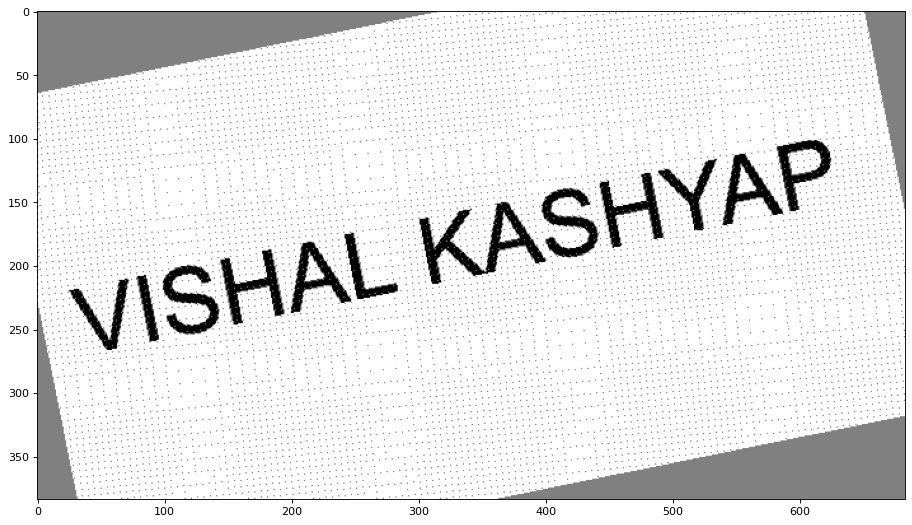

In [120]:
im_new = ICV_rotate_image_fwd(im,0.2,"rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_new,cmap='gray')

performing shear


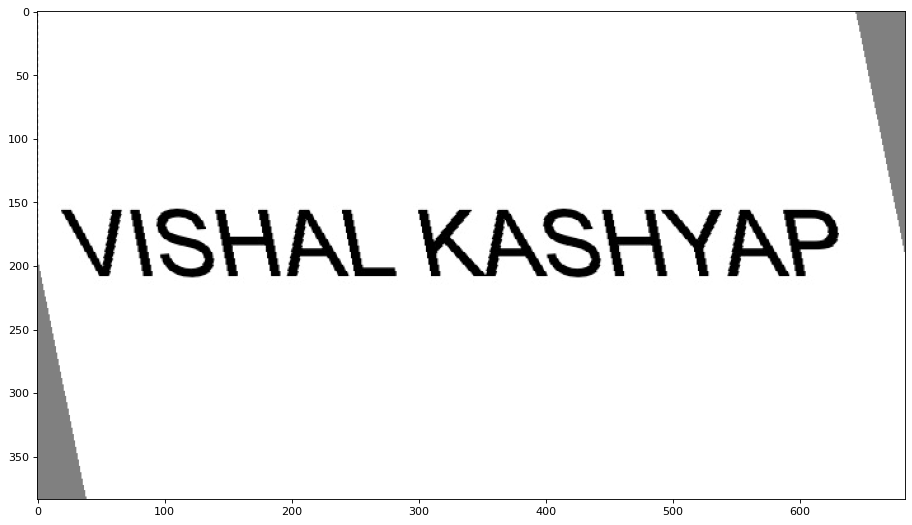

In [115]:
im_new = ICV_rotate_image_fwd(im, 0.2,"shear")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_new,cmap='gray')

## Try inverse warping

In [178]:
# function to rotate image clockwise by angle theta (inverse warping)
# input : image, angle to rotate (clockwise)
# output : rotated image

def ICV_rotate_image_inv(im_old, theta, mode,transformation):

    # step 1 : find center of image = int(max_row/col /2)
    x_center = int(im_old.shape[1]/2.0)
    y_center = int(im_old.shape[0]/2.0)
    
    # step 2 : Use nearest neighbour interpolation to fill pixel values in new image
    
    # new rotated image, initially all grey
    im_new = np.zeros(im_old.shape) + 128.0
    
    # inverse rotation matrix
    if transformation == "rotation":
        rot_mat_inv = np.array([[np.cos(theta) , np.sin(theta)] , [-np.sin(theta) , np.cos(theta)]]).T
    if transformation == "shear":
        rot_mat_inv = np.array([[1 , -np.tan(theta)] , [0 , 1]])
    print("performing", transformation)
    
    #iterate through each pixel and rotate
    for i in range(im_new.shape[0]):
        for j in range(im_new.shape[1]):
            
            # image center wont rotate , so continue
            if(i==y_center and j==x_center):
                continue
            
            # inverese rotate pixel cordinates, to get original pixel cordinates
            new_cordinate = np.array([j-x_center, i-y_center])
            old_cordinate = np.matmul(rot_mat_inv, new_cordinate)
            
            # translate the center back to top-left of image
            old_cordinate = old_cordinate + np.array([x_center,y_center])
            
            #  and store in new image array
            # perform nearest neighbour or bilinear interpolation depending on "mode"
            if mode == "NNI":
  
                # find nearest pixel to cordinate obatained after rotation.
                old_row = int(np.rint(old_cordinate[1]))
                old_col = int(np.rint(old_cordinate[0]))
                
                # check if cordinates obtained after inverse rotation are out of image
                out_of_image = old_col >= im_old.shape[1] or old_row >= im_old.shape[0]
                if np.sum(old_cordinate<0) or out_of_image:
                    continue

                im_new[i,j] = im_old[old_row,old_col]
            
            # if we want to do bilinear interpolation to fill pixels
            if mode == "BLI":
                x1 = int(np.floor(old_cordinate[0]))
                x2 = int(np.ceil(old_cordinate[0]))
                y1 = int(np.floor(old_cordinate[1]))
                y2 = int(np.ceil(old_cordinate[1]))
                x0 = old_cordinate[0]
                y0 = old_cordinate[1]
                
                # check if any of the points, x1,x2,y1,y2 lies outside image, continue
                if(x1 < 0 or x2 >= im_old.shape[1]):
                    continue
                if(y1 < 0 or y2 >= im_old.shape[0]):
                    continue

                fQ11 = im_old[y1,x1]
                fQ12 = im_old[y2,x1]
                fQ21 = im_old[y1,x2]
                fQ22 = im_old[y2,x2]
                
#                 Q = np.array([[fQ11,fQ12],[fQ21,fQ22]])
#                 im_new[i,j] = np.matmul(np.array([x2-x0,x0-x1]),np.matmul(Q,np.array([y2-y0,y0-y1]).T))
#                 im_new[i,j] = im_new[i,j]/(x2-x1)/(y2-y1)

                if transformation == "rotation":

                    fR1 = (x2-x0)/(x2-x1)*fQ11 + (x0-x1)/(x2-x1)*fQ21
                    fR2 = (x2-x0)/(x2-x1)*fQ12 + (x0-x1)/(x2-x1)*fQ22

                    im_new[i,j] = (y2-y0)/(y2-y1)*fR1 + (y0-y1)/(y2-y1)*fR2
                
                # since in shear y coordinate remains same
                if transformation == "shear":
                    
                    # on center line image will have no shear, so fill old value for those points
                    if i==y_center:
                        im_new[i,j] = im_old[i,j]
                        continue
                        
                    im_new[i,j] = (x2-x0)/(x2-x1)*fQ11 + (x0-x1)/(x2-x1)*fQ21
                
#                 print("4 values", fQ11,fQ21,fQ12,fQ22)
#                 print("corodinates",x0,y0,x1,y1,x2,y2)
#                 print("new value",im_new[i,j])
            
    return im_new
    

### Nearest neighbour interpolation

performing rotation


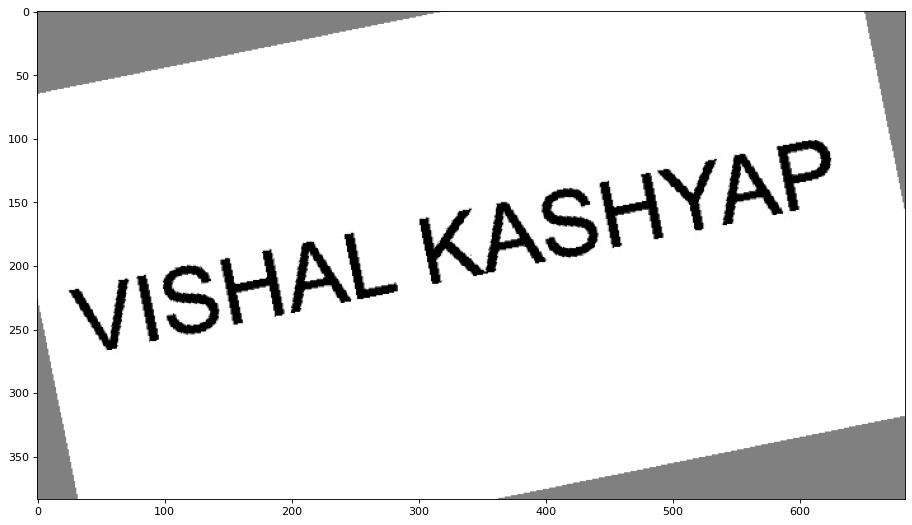

In [149]:
im_NNI = ICV_rotate_image_inv(im, 0.2, "NNI","rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_NNI,cmap='gray')

performing shear


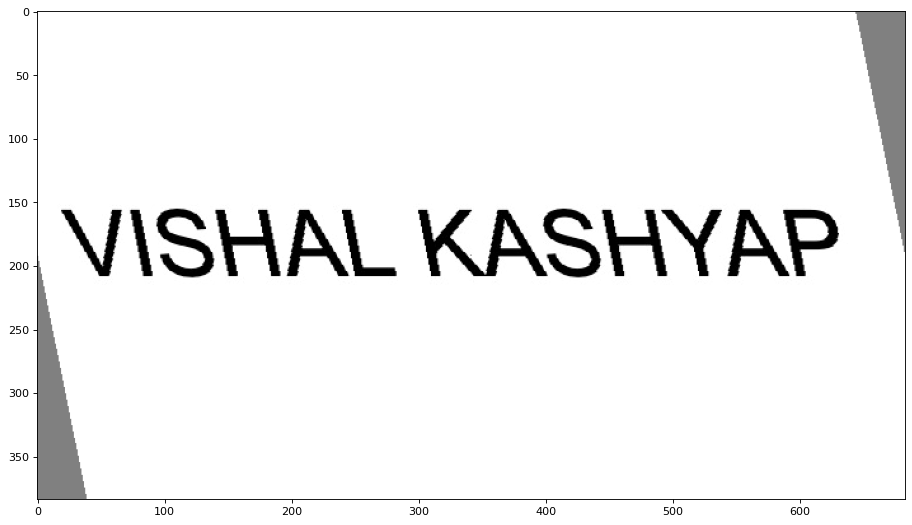

In [150]:
im_NNI = ICV_rotate_image_inv(im, 0.2, "NNI","shear")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_NNI,cmap='gray')

## Bilinear Interpolation

performing rotation


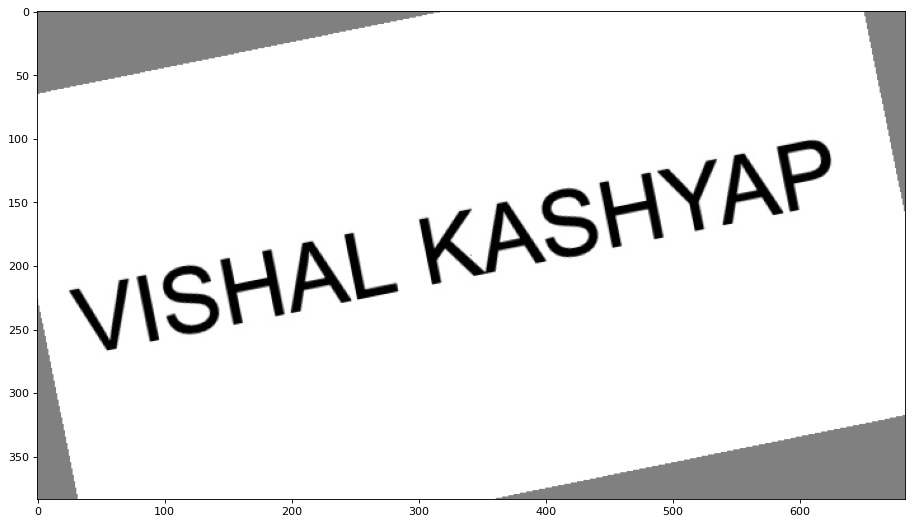

In [168]:
im_BLI = ICV_rotate_image_inv(im, 0.2, "BLI","rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI,cmap='gray')

performing shear


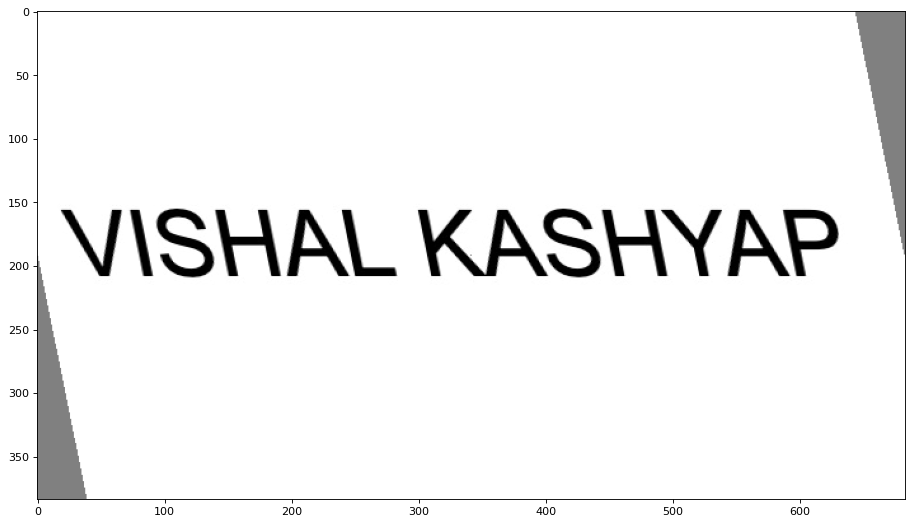

In [179]:
im_BLI = ICV_rotate_image_inv(im, 0.2, "BLI","shear")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI,cmap='gray')

### Rotate and then shear using BLI

performing rotation
performing shear


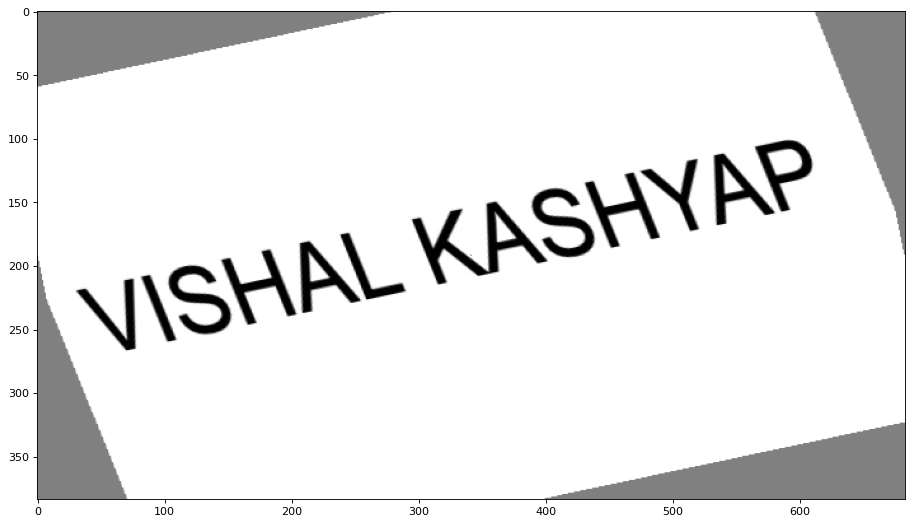

In [181]:
im_BLI_rotate = ICV_rotate_image_inv(im, 0.2, "BLI","rotation")
im_BLI_rotshear = ICV_rotate_image_inv(im_BLI_rotate, 0.2, "BLI","shear")

figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI_rotshear,cmap='gray')

performing shear
performing rotation


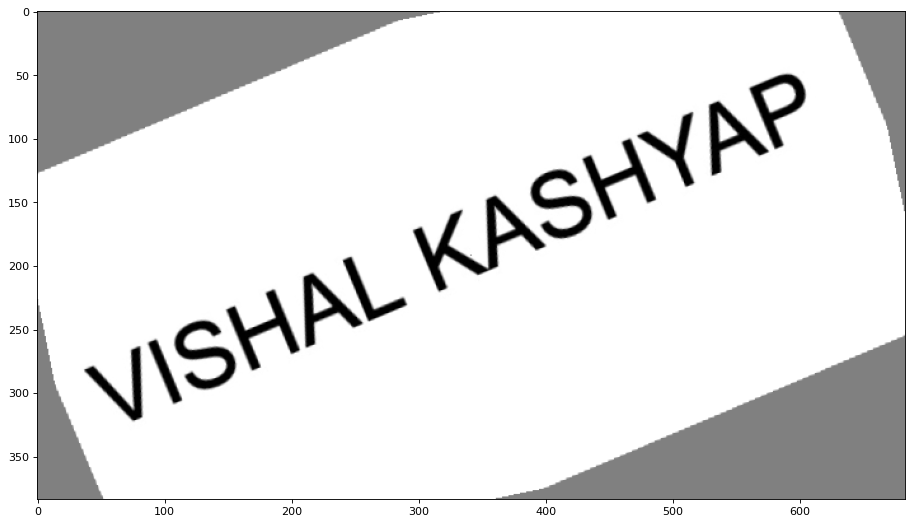

In [182]:
im_BLI_shear = ICV_rotate_image_inv(im, 0.2, "BLI","shear")
im_BLI_rotshear = ICV_rotate_image_inv(im_BLI_rotate, 0.2, "BLI","rotation")

figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI_rotshear,cmap='gray')